In [1]:
import sqlite3 as db
import pandas as pd
import numpy as np
from pandas.io import sql
import pylab
import math
%matplotlib inline  

In [2]:
assets = pd.read_csv('IndexData.csv', parse_dates=True, index_col='Date')
libor = pd.read_csv('LIBOR.csv', parse_dates=True, index_col='Date')

assets.reset_index(inplace=True)
assets['Date'] = pd.to_datetime(assets['Date'])
assets.set_index('Date', inplace = True)

libor.reset_index(inplace=True)
libor['Date'] = pd.to_datetime(libor['Date'])
libor.set_index('Date', inplace = True)

prices = pd.merge(assets.reset_index(), libor.reset_index(), how='inner',on='Date').set_index('Date')

In [3]:
cnx = db.connect('portfolio_data.db')
cnx.execute('DROP TABLE IF EXISTS Prices')
sql.to_sql(prices, name='Prices', con=cnx)

In [4]:
prices_check = pd.read_sql_query("SELECT * FROM Prices", con = cnx, index_col='Date')
returns = prices[1:].values/prices[:-1]-1
cnx.execute('DROP TABLE IF EXISTS Returns')
sql.to_sql(returns, name='Returns', con=cnx)

In [5]:
def add_libor(omg):
    omg.set_value(u'LIBOR',1-sum(omg))
    return omg

def create_portfolio(returns, omg, begin = None, end = None):
    port_rets = returns.dot(omg)
    if begin:
        port_rets = port_ret.loc[begin:]
    if end:
        port_rets = port_ret.loc[:end]
    return port_rets

def create_6040_portfolio(returns, begin = None, end = None):
    
    # 60% stocks, 40% bonds
    stocks = .6
    bonds = .4
    
    #stocks
    smallcap = .1
    midcap = .3
    largecap = .6
    
    #bonds
    igcorp = .5
    longT = .25
    medT = .25
    
    weights = {
        u'Gold':.0,
        u'Preferred':.0,
        u'IGCorp':igcorp*bonds,
        u'HYCorp':.0,
        u'LevLoan':.0,
        u'Emerging':.0,
        u'RealEstate':.0,
        u'MedTreas':medT*bonds,
        u'LongTreas':longT*bonds,
        u'TIPS':.0,
        u'GSCI':.0,
        u'DevXUS':.0,
        u'LargeCap':largecap*stocks,
        u'MidCap':midcap*stocks,
        u'SmallCap':smallcap*stocks,
    }
    omg = pd.Series(weights)
    omg = add_libor(omg)
    
    return create_portfolio(returns, omg, begin, end)

# Graphs

def generate_portfolio_nav(returns, begin_nav=100):
    return (returns+1).cumprod()*begin_nav

def rolling_portfolio_vol(returns, window=252):
    return returns.rolling(window=window,center=False).std()*math.sqrt(252)
    #return pd.rolling_std(returns, window=window)*math.sqrt(252)


def portfolio_drawdown(returns, begin_nav=100):   
    nav = generate_portfolio_nav(returns, begin_nav)
    bDate = nav.index[0]
    dd = pd.Series(begin_nav, index = [bDate])
    for date in nav.index:
        if date <= bDate:
            pass
        if nav.loc[date] >= max(nav.loc[bDate:date]):
            dd.set_value(date,begin_nav)
        else:
            loc = nav.index.get_loc(date)
            dd.set_value(date, dd.iloc[-1]*nav.iloc[loc]/nav.iloc[loc-1])
    return dd

def rolling_portfolio_sharpe_ratio(returns, libor, window=252):
    r = returns.rolling(window=window, center=False).apply(lambda x: np.prod(1+x)-1)
    rf = libor.rolling(window=window, center=False).apply(lambda x: np.prod(1+x)-1)
    sig = rolling_portfolio_vol(returns, window=window)
    return (r-rf)/sig

In [6]:
weights = {
u'Gold':.2,
u'Preferred':.2,
u'IGCorp':.1,
u'HYCorp':.2,
u'LevLoan':.05,
u'Emerging':.15,
u'RealEstate':0,
u'MedTreas':0,
u'LongTreas':0,
u'TIPS':0,
u'GSCI':0,
u'DevXUS':0,
u'LargeCap':0,
u'MidCap':0,
u'SmallCap':0,
}
omg = pd.Series(weights)
omg = add_libor(omg)
my_port_rets = create_portfolio(returns, omg)
my_port_vol = rolling_portfolio_vol(my_port_rets)
my_port_nav = generate_portfolio_nav(my_port_rets,100)
my_dd = portfolio_drawdown(my_port_rets)
my_sharpe = rolling_portfolio_sharpe_ratio(my_port_rets,returns['LIBOR'])
pd.concat([my_port_rets,my_port_vol,my_port_nav,my_dd,my_sharpe], axis=1).to_csv('mydata.csv')

In [7]:
sixtyforty = create_6040_portfolio(returns)
vol6040 = rolling_portfolio_vol(sixtyforty)
sixtyforty_nav = generate_portfolio_nav(sixtyforty,100)
dd6040 = portfolio_drawdown(sixtyforty)
sharpe6040 = rolling_portfolio_sharpe_ratio(sixtyforty,returns['LIBOR'])
pd.concat([sixtyforty,vol6040,sixtyforty_nav,dd6040,sharpe6040], axis=1).to_csv('data6040.csv')

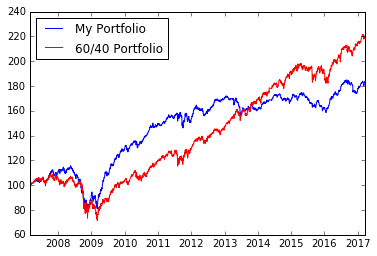

In [8]:
pylab.plot(my_port_nav, '-b', label=u'My Portfolio')
pylab.plot(sixtyforty_nav, '-r', label=u'60/40 Portfolio')
pylab.legend(loc='best')
pylab.show()

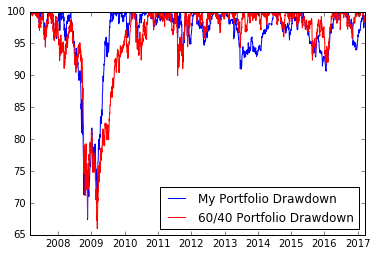

In [9]:
pylab.plot(my_dd, '-b', label=u'My Portfolio Drawdown')
pylab.plot(dd6040, '-r', label=u'60/40 Portfolio Drawdown')
pylab.legend(loc='best')
pylab.show()

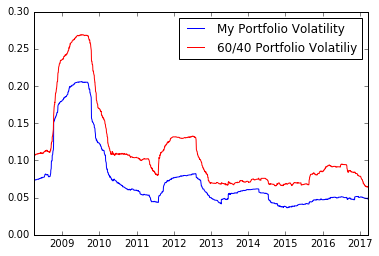

In [10]:
pylab.plot(my_port_vol, '-b', label=u'My Portfolio Volatility')
pylab.plot(vol6040, '-r', label=u'60/40 Portfolio Volatiliy')
pylab.legend(loc='best')
pylab.show()

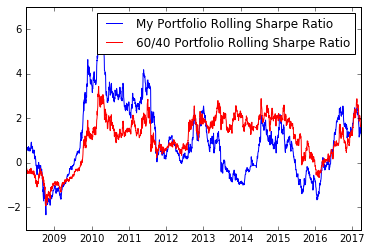

In [11]:
pylab.plot(my_sharpe, '-b', label=u'My Portfolio Rolling Sharpe Ratio')
pylab.plot(sharpe6040, '-r', label=u'60/40 Portfolio Rolling Sharpe Ratio')
pylab.legend(loc='best')
pylab.show()